In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from datetime import datetime
import math, statistics
import random

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
random.seed(2)
tf.random.set_seed(2)

In [4]:
df_unstructure = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Project/CP2/df_unstructure.csv", index_col=0)

In [5]:
df_unstructure

gamer_id  ...  y
0         0001b282486938b2735e00ea3a65a6af52d648c15bfaa8...  ...  0
805       000363849c2c6acfb7a2d73c7d9d90f8a5f01c2d48911b...  ...  1
841       0006ac69f100d4c902b1ac183ab25f7b529d708312235c...  ...  0
1189      00073f4afcaaf43fcdbd09d97649a915fa5730cd7f62c8...  ...  1
1192      00081a429467d20717bc4c94bc48a348fa41352a3dba1f...  ...  0
...                                                     ...  ... ..
23017939  ff1a7945ccf2a3b6fa82093208353d518f19d7e2b1c225...  ...  1
23017944  ff2470d693544f40c8d63d8c8e88541c51b056dcc56b35...  ...  1
23017948  ff4247ef5d22fd1abc6bdb098bb5304e2261fc1473c2ec...  ...  1
23017956  ff6a7cb86d4a4bc26e8f911c84f25791d1f8b3c67e19c6...  ...  1
23017962  ff7e04acdb9d089c5a6fff1c1b4150156e6183dacc1f3b...  ...  1

[545912 rows x 3 columns]

# Pad and encode texts

In [6]:
# 문장별 단어 토큰화 : 1분 23초
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_unstructure['day_cat_act'])
# tokens = [word_tokenize(sentence) for sentence in df_unstructure['day_cat_act']]

In [7]:
tokenizer

In [8]:
# sample
print('총 샘플의 개수 : {}'.format(len(df_unstructure['day_cat_act'])))

# vocab size 계산
vocab_size = len(tokenizer.word_index) + 1
print('vocab size : {}'.format(vocab_size))

# 정수 인코딩
X_encoded = tokenizer.texts_to_sequences(df_unstructure['day_cat_act'])
print('encoded text example : {}'.format(X_encoded[0]))

# max length 계산
max_len = max(len(i) for i in X_encoded)
print('max length : {}'.format(max_len))

총 샘플의 개수 : 545912
vocab size : 31514
encoded text example : [7, 4664, 61, 1971, 3313, 14, 83, 922, 1813, 671, 11, 6402, 643, 2051, 3509, 27, 108, 873, 2061, 997, 4, 2529, 61, 2028, 3096, 14, 83, 735, 1929, 700, 6, 4262, 131, 2131, 3754, 14, 62, 633, 1791, 5095, 8, 1363, 110, 1656, 3791, 246, 517, 1840, 975, 3, 2839, 504, 2222, 2778, 43, 83, 1078, 1787, 892, 10, 1003, 58, 1919, 3313, 27, 48, 915, 1708, 408]
max length : 77


In [9]:
# padding
X = pad_sequences(X_encoded, maxlen=max_len, padding='post')
y = np.array(df_unstructure['y'])

In [10]:
X.shape

(545912, 77)

In [11]:
y.shape

(545912,)

# Load Word2Vec models

In [12]:
# Saved model Load
wv_model_64 = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Colab_Notebooks/Project/CP2/wv_model_64')
wv_model_128 = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Colab_Notebooks/Project/CP2/wv_model_128')
wv_model_256 = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Colab_Notebooks/Project/CP2/wv_model_256')

In [13]:
# wv model vector shape
print(wv_model_64.vectors.shape)
print(wv_model_128.vectors.shape)
print(wv_model_256.vectors.shape)

(31513, 64)
(31513, 128)
(31513, 256)


# Create Embedding Matrix

In [14]:
# embedding matrix shape

# dim = 64
embedding_matrix_64 = np.zeros((vocab_size, 64))
print(np.shape(embedding_matrix_64))

# dim = 128
embedding_matrix_128 = np.zeros((vocab_size, 128))
print(np.shape(embedding_matrix_128))

# dim = 256
embedding_matrix_256 = np.zeros((vocab_size, 256))
print(np.shape(embedding_matrix_256))

(31514, 64)
(31514, 128)
(31514, 256)


In [15]:
# 각 모델별 word vectors
def get_vector_64(word):
    if word in wv_model_64:
        return wv_model_64[word]
    else:
        return None

def get_vector_128(word):
    if word in wv_model_128:
        return wv_model_128[word]
    else:
        return None

def get_vector_256(word):
    if word in wv_model_256:
        return wv_model_256[word]
    else:
        return None

In [16]:
# 각 모델별 embedding matrix 생성
for word, idx in tokenizer.word_index.items():
    temp = get_vector_64(word)
    if temp is not None:
        embedding_matrix_64[idx] = temp

for word, idx in tokenizer.word_index.items():
    temp = get_vector_128(word)
    if temp is not None:
        embedding_matrix_128[idx] = temp

for word, idx in tokenizer.word_index.items():
    temp = get_vector_256(word)
    if temp is not None:
        embedding_matrix_256[idx] = temp

In [17]:
# index = 1 부터 임베딩 시작 ==> tokenizer.word_index 가 1부터 인덱스를 매기기 때문
shape_64 = np.shape(embedding_matrix_64)
shape_128 = np.shape(embedding_matrix_128)
shape_256 = np.shape(embedding_matrix_256)

print(shape_64)
print(shape_128)
print(shape_256)
# embedding_matrix[0] == 0 행렬

(31514, 64)
(31514, 128)
(31514, 256)


In [18]:
embedding_matrix_64[0:3]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [-1.21139801, -1.57548273,  1.83801866,  1.81747794, -0.

# CNN Modeling

In [19]:
#  데이터분할 (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2, random_state=42)

In [20]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(436729, 77)
(109183, 77)
(436729,)
(109183,)


In [ ]:
num_filters = 100
kernel_size = 3
dropout_rate = 0.3
hidden_dim = 128
output_dim = 1
BATCH_SIZE = 512
NUM_EPOCHS = 100
VALID_SPLIT = 0.2


model64 = Sequential()
Embed = Embedding(vocab_size, 64, weights=[embedding_matrix_64], input_length=max_len, trainable=False)
model64.add(Embed)
model64.add(Conv1D(num_filters, kernel_size=kernel_size, padding='valid', activation='relu'))
model64.add(GlobalMaxPooling1D())
model64.add(Dropout(dropout_rate))
model64.add(Dense(units=hidden_dim, activation='relu'))
model64.add(Dense(units=1, activation='sigmoid')) # 0.0~1.0 실수로 출력

In [ ]:
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model64.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, verbose=0, mode='auto')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history64 = model64.fit(X_train, y_train,
                    epochs=NUM_EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_split=VALID_SPLIT,
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/100
683/683 [==============================] - 8s 8ms/step - loss: 0.5515 - acc: 0.7160 - val_loss: 0.4878 - val_acc: 0.7527
Epoch 2/100
683/683 [==============================] - 4s 7ms/step - loss: 0.4771 - acc: 0.7558 - val_loss: 0.4434 - val_acc: 0.7709
Epoch 3/100
683/683 [==============================] - 5s 7ms/step - loss: 0.4507 - acc: 0.7678 - val_loss: 0.4273 - val_acc: 0.7799
Epoch 4/100
683/683 [==============================] - 4s 6ms/step - loss: 0.4398 - acc: 0.7742 - val_loss: 0.4189 - val_acc: 0.7860
Epoch 5/100
683/683 [==============================] - 4s 6ms/step - loss: 0.4316 - acc: 0.7793 - val_loss: 0.4214 - val_acc: 0.7847
Epoch 6/100
683/683 [==============================] - 4s 6ms/step - loss: 0.4256 - acc: 0.7833 - val_loss: 0.4139 - val_acc: 0.7889
Epoch 7/100
683/683 [==============================] - 4s 6ms/step - loss: 0.4209 - acc: 0.7858 - val_loss: 0.4121 - val_acc: 0.7898
Epoch 8/100
683/683 [==============================] - 5s 7ms/step - 

# Predict

In [ ]:
# 확률값
y_pred = model64.predict(X_test)

In [ ]:
# 클래스
y_pred_class = np.around(y_pred)

In [ ]:
y_pred_class

array([[1.],
       [0.],
       [1.],
       ...,
       [1.],
       [0.],
       [0.]], dtype=float32)

# CNN Modeling with embedding dimension 128

In [ ]:
num_filters = 100
kernel_size = 3
dropout_rate = 0.3
hidden_dim = 128
output_dim = 1
BATCH_SIZE = 512
NUM_EPOCHS = 100
VALID_SPLIT = 0.2


model128 = Sequential()
Embed = Embedding(vocab_size, 128, weights=[embedding_matrix_128], input_length=max_len, trainable=False)
model128.add(Embed)
model128.add(Conv1D(num_filters, kernel_size=kernel_size, padding='valid', activation='relu'))
model128.add(GlobalMaxPooling1D())
model128.add(Dropout(dropout_rate))
model128.add(Dense(units=hidden_dim, activation='relu'))
model128.add(Dense(units=1, activation='sigmoid')) # 0.0~1.0 실수로 출력

In [ ]:
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model128.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, verbose=0, mode='auto')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history128 = model128.fit(X_train, y_train,
                       epochs=NUM_EPOCHS,
                       batch_size=BATCH_SIZE,
                       validation_split=VALID_SPLIT,
                       verbose=1,
                       callbacks=[early_stopping])

Epoch 1/100
683/683 [==============================] - 6s 8ms/step - loss: 0.5003 - acc: 0.7418 - val_loss: 0.4364 - val_acc: 0.7750
Epoch 2/100
683/683 [==============================] - 5s 8ms/step - loss: 0.4361 - acc: 0.7760 - val_loss: 0.4147 - val_acc: 0.7899
Epoch 3/100
683/683 [==============================] - 5s 8ms/step - loss: 0.4216 - acc: 0.7849 - val_loss: 0.4018 - val_acc: 0.7979
Epoch 4/100
683/683 [==============================] - 5s 8ms/step - loss: 0.4138 - acc: 0.7888 - val_loss: 0.3978 - val_acc: 0.7973
Epoch 5/100
683/683 [==============================] - 5s 8ms/step - loss: 0.4085 - acc: 0.7923 - val_loss: 0.3937 - val_acc: 0.8020
Epoch 6/100
683/683 [==============================] - 5s 8ms/step - loss: 0.4046 - acc: 0.7948 - val_loss: 0.3942 - val_acc: 0.7987
Epoch 7/100
683/683 [==============================] - 5s 8ms/step - loss: 0.4011 - acc: 0.7966 - val_loss: 0.3891 - val_acc: 0.8019
Epoch 8/100
683/683 [==============================] - 5s 8ms/step - 

# Predict

In [ ]:
# 확률값
y_pred = model128.predict(X_test)

In [ ]:
y_pred

array([[0.98400545],
       [0.00981655],
       [0.55913585],
       ...,
       [0.9982054 ],
       [0.34161922],
       [0.3649531 ]], dtype=float32)

In [ ]:
# 클래스
y_pred_class = np.around(y_pred)

In [ ]:
y_pred_class

array([[1.],
       [0.],
       [1.],
       ...,
       [1.],
       [0.],
       [0.]], dtype=float32)

# CNN Modeling with embedding dimension 256

In [21]:
num_filters = 100
kernel_size = 3
dropout_rate = 0.3
hidden_dim = 128
output_dim = 1
BATCH_SIZE = 512
NUM_EPOCHS = 100
VALID_SPLIT = 0.2


model256 = Sequential()
Embed = Embedding(vocab_size, 256, weights=[embedding_matrix_256], input_length=max_len, trainable=False)
model256.add(Embed)
model256.add(Conv1D(num_filters, kernel_size=kernel_size, padding='valid', activation='relu'))
model256.add(GlobalMaxPooling1D())
model256.add(Dropout(dropout_rate))
model256.add(Dense(units=hidden_dim, activation='relu'))
model256.add(Dense(units=1, activation='sigmoid')) # 0.0~1.0 실수로 출력

In [22]:
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model256.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, verbose=0, mode='auto')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [23]:
history256 = model256.fit(X_train, y_train,
                       epochs=NUM_EPOCHS,
                       batch_size=BATCH_SIZE,
                       validation_split=VALID_SPLIT,
                       verbose=1,
                       callbacks=[early_stopping])

Epoch 1/100
683/683 [==============================] - 24s 22ms/step - loss: 0.4883 - acc: 0.7494 - val_loss: 0.4263 - val_acc: 0.7806
Epoch 2/100
683/683 [==============================] - 15s 22ms/step - loss: 0.4333 - acc: 0.7780 - val_loss: 0.4182 - val_acc: 0.7868
Epoch 3/100
683/683 [==============================] - 14s 20ms/step - loss: 0.4196 - acc: 0.7856 - val_loss: 0.4014 - val_acc: 0.7964
Epoch 4/100
683/683 [==============================] - 14s 20ms/step - loss: 0.4124 - acc: 0.7901 - val_loss: 0.3983 - val_acc: 0.7961
Epoch 5/100
683/683 [==============================] - 15s 22ms/step - loss: 0.4073 - acc: 0.7929 - val_loss: 0.3946 - val_acc: 0.7992
Epoch 6/100
683/683 [==============================] - 14s 20ms/step - loss: 0.4049 - acc: 0.7948 - val_loss: 0.3942 - val_acc: 0.8000
Epoch 7/100
683/683 [==============================] - 15s 22ms/step - loss: 0.4011 - acc: 0.7962 - val_loss: 0.3900 - val_acc: 0.8027
Epoch 8/100
683/683 [==============================] - 

# Predict

In [24]:
# 확률값
y_pred256 = model256.predict(X_test)

In [25]:
y_pred256

array([[0.99838746],
       [0.00215573],
       [0.5634821 ],
       ...,
       [0.99944776],
       [0.4987971 ],
       [0.4057507 ]], dtype=float32)

In [39]:
# 클래스
y_pred_class256 = np.around(y_pred256)

In [40]:
y_pred_class256

array([[1.],
       [0.],
       [1.],
       ...,
       [1.],
       [0.],
       [0.]], dtype=float32)

In [35]:
# X전체: 확률값
y_pred256_total = model256.predict(X)

In [36]:
y_pred256_total_reshaped = y_pred256_total.reshape(-1)
y_pred256_total_list = list(y_pred256_total_reshaped)

In [37]:
y_pred_proba_df = pd.DataFrame(data={'y_pred_proba':y_pred256_total_list})

In [38]:
y_pred_proba_df

y_pred_proba
0           0.030249
1           0.629986
2           0.074241
3           0.751685
4           0.263305
...              ...
545907      0.574230
545908      0.672407
545909      0.846521
545910      0.846272
545911      0.812211

[545912 rows x 1 columns]

In [44]:
y_pred_proba_df.to_csv('y_pred_proba.csv', mode='w')

# Confusion Matrix

In [45]:
# confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred_class256)
confusion_matrix = pd.DataFrame(confusion_matrix, index=['실제값(N)', '실제값(P)'], columns=['예측값(N)', '예측값(P)'])

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44050 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44050 missing from current font.
  font.set_text

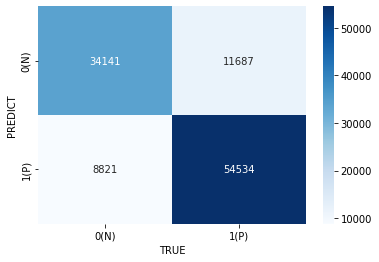

In [46]:
sns.heatmap(confusion_matrix, annot = True, fmt = 'd',cmap = 'Blues')
plt.xlabel('TRUE')
plt.ylabel('PREDICT')
plt.xticks([0.5,1.5],['0(N)', '1(P)'])
plt.yticks([0.5,1.5],['0(N)', '1(P)'])
plt.show();

In [ ]:
report64 = classification_report(y_test, y_pred_class)
print(report64)

              precision    recall  f1-score   support

           0       0.78      0.76      0.77     45828
           1       0.83      0.85      0.84     63355

    accuracy                           0.81    109183
   macro avg       0.81      0.80      0.80    109183
weighted avg       0.81      0.81      0.81    109183



In [ ]:
report128 = classification_report(y_test, y_pred_class)
print(report128)

              precision    recall  f1-score   support

           0       0.78      0.76      0.77     45828
           1       0.83      0.85      0.84     63355

    accuracy                           0.81    109183
   macro avg       0.81      0.80      0.81    109183
weighted avg       0.81      0.81      0.81    109183



In [ ]:
report256 = classification_report(y_test, y_pred_class256)
print(report256)

              precision    recall  f1-score   support

           0       0.79      0.75      0.77     45828
           1       0.82      0.86      0.84     63355

    accuracy                           0.81    109183
   macro avg       0.81      0.80      0.81    109183
weighted avg       0.81      0.81      0.81    109183



# Evaluate

In [ ]:
print("Evaluate on test data")
result64 = model64.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", result64)

Evaluate on test data
853/853 [==============================] - 2s 3ms/step - loss: 0.3791 - acc: 0.8102
test loss, test acc: [0.3790718913078308, 0.8101993799209595]


In [ ]:
print("Evaluate on test data")
result128 = model128.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", result128)

Evaluate on test data
853/853 [==============================] - 3s 3ms/step - loss: 0.3729 - acc: 0.8112
test loss, test acc: [0.3728622794151306, 0.811170220375061]


In [ ]:
print("Evaluate on test data")
result256 = model256.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", result256)

Evaluate on test data
853/853 [==============================] - 3s 3ms/step - loss: 0.3740 - acc: 0.8122
test loss, test acc: [0.3739900588989258, 0.8122051954269409]


In [43]:
print("Evaluate on test data")
result256_total = model256.evaluate(X, y, batch_size=512)
print("test loss, test acc:", result256_total)

Evaluate on test data
1067/1067 [==============================] - 10s 10ms/step - loss: 0.3646 - acc: 0.8188
test loss, test acc: [0.3646080791950226, 0.8187857866287231]
